In [1]:
import os, re, glob, json
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']=''

import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from ohia.encoders import FastLabelEncoder
from ohia.generators import PlantNetGenerator
from train import get_model, get_model_path

import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot 

Using TensorFlow backend.


#### Preliminaries

In [3]:
# get list of images and labels
FILE_PATH = '/home/matt/repos/ohia.ai/data'
file_list = glob.glob(f'{FILE_PATH}/preprocessed_images/scraped_filtered/**/*.jpg', recursive=True)
label_list = [re.split('/', f)[-2] for f in file_list]

# encode label names with ids
fle = FastLabelEncoder()
label_ids = fle.fit_transform(label_list)

# id to label lookup
id2label = {int(fle.transform([label])):label for label in np.unique(label_list)}

# split data
train_files, valid_files, train_ids, valid_ids \
    = train_test_split(file_list, label_ids, test_size=0.1, random_state=1)

# create generators
n_classes = len(np.unique(label_list))
valid_generator = PlantNetGenerator(
    valid_files, valid_ids, n_classes,
    batch_size=32,
    augment=False,
    shuffle=False
)

# load model
model = get_model('mobilenetv1', n_classes, training_type=0)
model_path = get_model_path('mobilenetv1', 1, 1, 32, False)
best_weights = glob.glob(f'{model_path}/**.h5')
best_weights = np.sort(best_weights)[-1]
model.load_weights(best_weights)

#### Top 1, Top 3, Top 5 Accuracy

In [4]:
# get sorted predictions
valid_preds = model.predict_generator(valid_generator)
pred_ids_sort = np.argsort(valid_preds, axis=1)

In [5]:
# get accuracy matrix
n_preds = len(valid_preds)
accuracy_matrix = pred_ids_sort == np.expand_dims(valid_ids[:n_preds], -1)

In [6]:
# get aggregate accuracies
top_1 = accuracy_matrix[:,-1:].sum(axis=1)>0
top_3 = accuracy_matrix[:,-3:].sum(axis=1)>0
top_5 = accuracy_matrix[:,-5:].sum(axis=1)>0
print(
    f'top 1:{100*np.mean(top_1): 0.2f}%,   '
    f'top 3:{100*np.mean(top_3): 0.2f}%,   '
    f'top 5:{100*np.mean(top_5): 0.2f}%'
)

top 1: 73.76%,   top 3: 88.74%,   top 5: 92.51%


#### Per Plant Results

In [7]:
# # aggregate accuracies
plant_results = pd.DataFrame({
    "labels": [id2label[i] for i in valid_ids[:n_preds]],
    "top_1": top_1,
    "top_3": top_3,
    "top_5": top_5
})

plant_results = plant_results.groupby(["labels"])
plant_results = plant_results.agg(['mean'])
plant_results.reset_index(inplace=True)
plant_results.columns = plant_results.columns.droplevel(1)

# add counts
counts = Counter([id2label[i] for i in train_ids])
counts = pd.DataFrame({
   'counts': list(counts.values()),
    'labels': list(counts.keys())
})

plant_results = pd.merge(plant_results, counts, on='labels')
plant_results

,labels,top_1,top_3,top_5,counts
0,Abutilon,0.805556,0.833333,0.888889,374
1,Achyranthes,0.531250,0.656250,0.781250,258
2,Aleurites,0.466667,0.800000,0.866667,176
3,Ananas,0.860000,0.900000,0.960000,612
4,Anthurium,0.739130,0.971014,0.971014,758
5,Artocarpus,0.730769,0.884615,0.884615,303
6,Bonamia,0.666667,0.666667,0.666667,44
7,Bougainvillea,0.963636,1.000000,1.000000,663
8,Canavalia,0.625000,0.791667,0.833333,212
9,Chrysodracon,0.636364,0.818182,0.818182,276


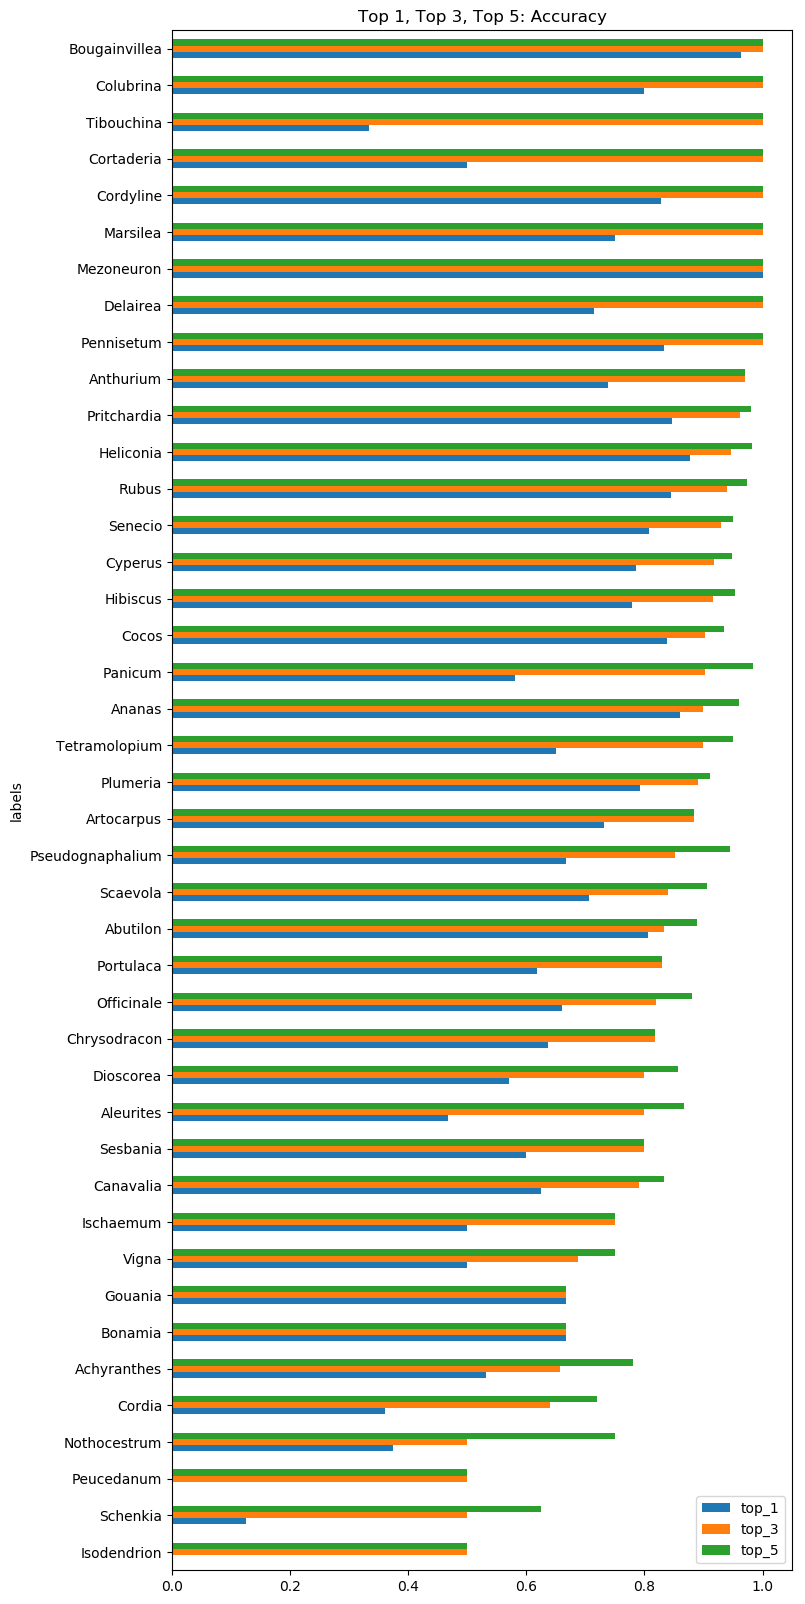

In [14]:
jtplot.reset()
plot_data = plant_results.set_index('labels').drop('counts', 1)
plot_data.sort_values('top_3', inplace=True)
plot_data.plot.barh(
    figsize=(8,20),
    title='Top 1, Top 3, Top 5: Accuracy'
)
plt.show()

#### Accuracy Vs. Training Size

/home/matt/anaconda3/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


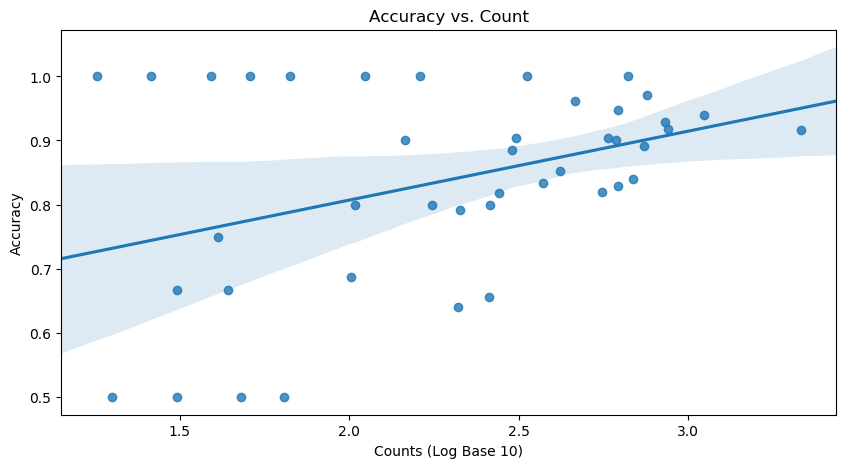

In [16]:
jtplot.reset()
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Accuracy vs. Count')
ax.set_xlabel('Counts (Log Base 10)')
ax.set_ylabel('Accuracy')
sns.regplot(
    np.log10(plant_results['counts'].values),
    plant_results['top_3'].values,
    ax=ax
)
plt.show()